In [1]:
# Save the Kaggle API key as a JSON file
! mkdir -p '/root/.kaggle/'
! echo '{"username":"essawey","key":"c724b5660a906e9c674ac7cb5fdc802a"}' >> /root/.kaggle/kaggle.json
! export KAGGLE_CONFIG_DIR="/root/.kaggle"
! chmod 600 /root/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d lampubhutia/email-spam-ham-prediction
! unzip -n -qq /content/email-spam-ham-prediction.zip
! rm /content/email-spam-ham-prediction.zip

100% 209k/209k [00:00<00:00, 412kB/s]
100% 209k/209k [00:00<00:00, 412kB/s]


In [3]:
!pip -qqq install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


In [4]:
import optuna
study = optuna.create_study(study_name = "study-1",
                            direction='maximize')

[I 2024-03-25 21:27:00,535] A new study created in memory with name: study-1


In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
def clean_text(text):
    text = re.sub('\[[^]]*\]', '', text)  # remove text in brackets
    text = re.sub(r'http\S+', '', text)  # remove URLs
    stop_words = set(stopwords.words('english'))  # Use NLTK's stopwords
    punctuation = list(string.punctuation)
    stop_words.update(punctuation)  # Add punctuation to stopwords list
    text = " ".join(word for word in text.split() if word.lower() not in stop_words)
    return text

In [7]:
import pandas as pd
data_path = '/content/sms_spam.csv'
data = pd.read_csv(data_path)
data['text'] = data['text'].apply(clean_text)
data = data.drop_duplicates()

In [8]:
data['length'] = data['text'].apply(len)
data['word_count'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1).apply(len)
data['sentence_count'] = data.apply(lambda row: nltk.sent_tokenize(row['text']), axis=1).apply(len)

<ipython-input-8-94029e25e8d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data['text'].apply(len)


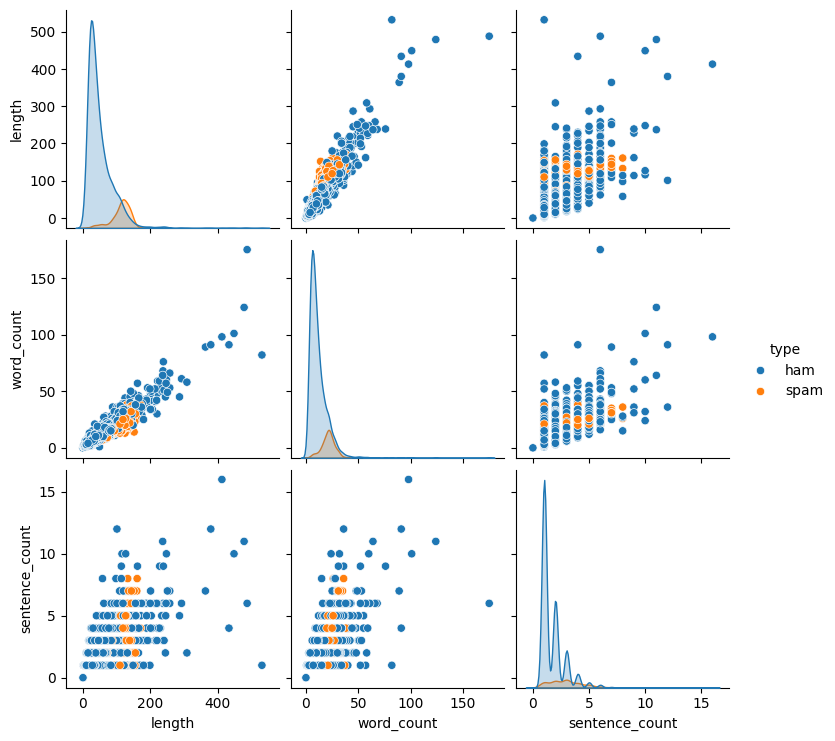

In [9]:
import seaborn as sns
sns.pairplot(data = data, hue="type");

In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

num_words = len(set(' '.join(data['text']).split()))
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(sequences, maxlen=5000)

In [11]:
label_mapping = {'ham': 1, 'spam': 0}
data['type'] = data['type'].map(label_mapping)

In [12]:
import numpy as np
import torch

y = torch.from_numpy(np.array(data['type'].values).reshape(-1,1))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

<ipython-input-14-ea5ed0fdacfa>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
<ipython-input-14-ea5ed0fdacfa>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


In [15]:
# Create a DataLoader
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
# Save the Tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
import torch.optim as optim
from tqdm.auto import tqdm
num_epochs = 8

In [19]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, embedding_dim, n_hidden, n_units, dropout_rate):
        super(NeuralNetwork, self).__init__()

        layers = [nn.Embedding(num_embeddings=num_words, embedding_dim=embedding_dim)]


        layers += [nn.Linear(embedding_dim, n_units), nn.ReLU(), nn.Dropout(dropout_rate)]

        for _ in range(n_hidden):
            layers += [nn.Linear(n_units, n_units), nn.ReLU(), nn.Dropout(dropout_rate)]

        layers += [nn.Linear(n_units, 1)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        logits = self.network(x)
        return logits

In [20]:
def create_model(trial):
    embedding_dim = trial.suggest_int('embedding_dim', 256, 1024, step=128)  # Increased range for embedding_dim
    n_hidden = trial.suggest_int('n_hidden', 2, 16, step=2)  # Increased range for hidden layers
    n_units = trial.suggest_int('n_units', 64, 256, step=64)  # Increased range for units per layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3, step=0.05)  # Suggesting dropout rate
    model = NeuralNetwork(embedding_dim, n_hidden, n_units, dropout_rate)
    return model.to(device)

In [21]:
# @title Objective Function
import torch.optim as optim
from sklearn.metrics import f1_score

def objective(trial):
    model = create_model(trial)  # Assuming create_model function is defined elsewhere
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_predictions = []
    val_predictions = []
    train_targets = []
    val_targets = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.to(device)
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            train_predictions.extend(predicted.tolist())
            train_targets.extend(y_batch.tolist())

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())
                _, predicted = torch.max(output.data, 1)
                val_predictions.extend(predicted.tolist())
                val_targets.extend(y_batch.tolist())

    train_f1 = f1_score(train_targets, train_predictions, average='weighted')
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')
    print("Training F1 Score:", train_f1)
    print("Validation F1 Score:", val_f1)
    return train_f1

In [22]:
study.optimize(objective, n_trials=32, n_jobs=1)

  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:28:02,181] Trial 0 finished with value: 0.04736594659883264 and parameters: {'embedding_dim': 384, 'n_hidden': 4, 'n_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.06225366550675409}. Best is trial 0 with value: 0.04736594659883264.


Training F1 Score: 0.04736594659883264
Validation F1 Score: 0.027014205208167073


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:33:07,965] Trial 1 finished with value: 0.07812129276912984 and parameters: {'embedding_dim': 640, 'n_hidden': 16, 'n_units': 192, 'dropout_rate': 0.25, 'learning_rate': 0.040333719599831536}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.07812129276912984
Validation F1 Score: 0.02834291608275518


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:36:38,979] Trial 2 finished with value: 0.00024255875471837902 and parameters: {'embedding_dim': 640, 'n_hidden': 10, 'n_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.02206129283861996}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.00024255875471837902
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:39:20,830] Trial 3 finished with value: 0.0006667830720782844 and parameters: {'embedding_dim': 384, 'n_hidden': 8, 'n_units': 192, 'dropout_rate': 0.25, 'learning_rate': 0.05004881668861497}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.0006667830720782844
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:40:53,342] Trial 4 finished with value: 0.07302317131293048 and parameters: {'embedding_dim': 640, 'n_hidden': 16, 'n_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.08830669561364494}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.07302317131293048
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:42:28,506] Trial 5 finished with value: 0.008129644759011845 and parameters: {'embedding_dim': 512, 'n_hidden': 2, 'n_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.07458415620269739}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.008129644759011845
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:45:12,297] Trial 6 finished with value: 0.027463152157204237 and parameters: {'embedding_dim': 640, 'n_hidden': 16, 'n_units': 128, 'dropout_rate': 0.25, 'learning_rate': 0.06522024776799831}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.027463152157204237
Validation F1 Score: 0.02974361008938201


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:46:03,880] Trial 7 finished with value: 0.07263363719591998 and parameters: {'embedding_dim': 640, 'n_hidden': 2, 'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.07977666268843621}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.07263363719591998
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:51:28,562] Trial 8 finished with value: 0.018165091054714186 and parameters: {'embedding_dim': 512, 'n_hidden': 12, 'n_units': 256, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.07246987795544353}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.018165091054714186
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:52:44,721] Trial 9 finished with value: 0.04438193184268477 and parameters: {'embedding_dim': 640, 'n_hidden': 12, 'n_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.07952472838289545}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.04438193184268477
Validation F1 Score: 0.029896657233993627


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:55:36,069] Trial 10 finished with value: 0.03351951299605466 and parameters: {'embedding_dim': 1024, 'n_hidden': 6, 'n_units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.01856582902298165}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.03351951299605466
Validation F1 Score: 0.028783673904269298


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 21:58:32,397] Trial 11 finished with value: 0.03266465962284141 and parameters: {'embedding_dim': 896, 'n_hidden': 16, 'n_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.03626247439282265}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.03266465962284141
Validation F1 Score: 0.02742613460998106


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:00:05,590] Trial 12 finished with value: 0.07590150899891189 and parameters: {'embedding_dim': 896, 'n_hidden': 14, 'n_units': 64, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.09448514853492762}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.07590150899891189
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:05:12,861] Trial 13 finished with value: 0.00030307437893166097 and parameters: {'embedding_dim': 896, 'n_hidden': 14, 'n_units': 192, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.0043230375910371655}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.00030307437893166097
Validation F1 Score: 0.02990728283428762


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:07:36,671] Trial 14 finished with value: 0.048071021647003276 and parameters: {'embedding_dim': 896, 'n_hidden': 12, 'n_units': 128, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.09726110510319673}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.048071021647003276
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:14:08,228] Trial 15 finished with value: 0.00042443381213599 and parameters: {'embedding_dim': 768, 'n_hidden': 14, 'n_units': 256, 'dropout_rate': 0.25, 'learning_rate': 0.04828455493113563}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.00042443381213599
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:15:20,563] Trial 16 finished with value: 0.05859291702525034 and parameters: {'embedding_dim': 256, 'n_hidden': 14, 'n_units': 64, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.038108993063306035}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.05859291702525034
Validation F1 Score: 0.027325862994814806


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:17:33,463] Trial 17 finished with value: 0.058499457637270734 and parameters: {'embedding_dim': 1024, 'n_hidden': 10, 'n_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.05502548501224133}. Best is trial 1 with value: 0.07812129276912984.


Training F1 Score: 0.058499457637270734
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:22:15,927] Trial 18 finished with value: 0.11589704553244774 and parameters: {'embedding_dim': 768, 'n_hidden': 14, 'n_units': 192, 'dropout_rate': 0.3, 'learning_rate': 0.031814277641583844}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.11589704553244774
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:25:24,805] Trial 19 finished with value: 0.0004850169287305616 and parameters: {'embedding_dim': 768, 'n_hidden': 8, 'n_units': 192, 'dropout_rate': 0.3, 'learning_rate': 0.02883455923566996}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.0004850169287305616
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:33:06,615] Trial 20 finished with value: 0.00030308929895735457 and parameters: {'embedding_dim': 768, 'n_hidden': 16, 'n_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.005001133168989931}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.00030308929895735457
Validation F1 Score: 0.024703307717912897


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:37:48,662] Trial 21 finished with value: 0.008752453135873844 and parameters: {'embedding_dim': 768, 'n_hidden': 14, 'n_units': 192, 'dropout_rate': 0.25, 'learning_rate': 0.03901900061237337}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.008752453135873844
Validation F1 Score: 0.029847238298045236


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:42:10,798] Trial 22 finished with value: 0.03771647064011117 and parameters: {'embedding_dim': 896, 'n_hidden': 12, 'n_units': 192, 'dropout_rate': 0.3, 'learning_rate': 0.015902417828723425}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.03771647064011117
Validation F1 Score: 0.029057510106203336


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:44:34,011] Trial 23 finished with value: 0.02597517005682588 and parameters: {'embedding_dim': 512, 'n_hidden': 14, 'n_units': 128, 'dropout_rate': 0.25, 'learning_rate': 0.02783532903960208}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.02597517005682588
Validation F1 Score: 0.029757929843975742


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:50:02,215] Trial 24 finished with value: 0.057026063178533454 and parameters: {'embedding_dim': 1024, 'n_hidden': 16, 'n_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.04440927437529065}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.057026063178533454
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:55:00,717] Trial 25 finished with value: 0.03280506146841005 and parameters: {'embedding_dim': 768, 'n_hidden': 10, 'n_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.05805224370916105}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.03280506146841005
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 22:57:41,021] Trial 26 finished with value: 0.034781886309290286 and parameters: {'embedding_dim': 896, 'n_hidden': 14, 'n_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.02954862901010958}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.034781886309290286
Validation F1 Score: 0.02904587180450853


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 23:01:50,047] Trial 27 finished with value: 0.0390745223347471 and parameters: {'embedding_dim': 768, 'n_hidden': 12, 'n_units': 192, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.09662704117722737}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.0390745223347471
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 23:03:32,952] Trial 28 finished with value: 0.04120575076342903 and parameters: {'embedding_dim': 896, 'n_hidden': 16, 'n_units': 64, 'dropout_rate': 0.25, 'learning_rate': 0.04066198232766613}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.04120575076342903
Validation F1 Score: 0.029834420072450196


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 23:04:19,321] Trial 29 finished with value: 0.07000572522198854 and parameters: {'embedding_dim': 512, 'n_hidden': 6, 'n_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.06470489490993336}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.07000572522198854
Validation F1 Score: 0.029448432939761373


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 23:08:34,919] Trial 30 finished with value: 0.0004848614988802282 and parameters: {'embedding_dim': 384, 'n_hidden': 14, 'n_units': 192, 'dropout_rate': 0.25, 'learning_rate': 0.05371514953044795}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.0004848614988802282
Validation F1 Score: 0.029898885618779222


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2024-03-25 23:10:07,627] Trial 31 finished with value: 0.03945434747362613 and parameters: {'embedding_dim': 640, 'n_hidden': 16, 'n_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.08857159815194597}. Best is trial 18 with value: 0.11589704553244774.


Training F1 Score: 0.03945434747362613
Validation F1 Score: 0.029898885618779222


In [23]:
# Create a model with the best hyperparameters found
print(study.best_params)
best_model = create_model(study.best_trial)

{'embedding_dim': 768, 'n_hidden': 14, 'n_units': 192, 'dropout_rate': 0.3, 'learning_rate': 0.031814277641583844}
